In [1]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer, SentencePieceBPETokenizer

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [3]:
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path('jigsaw-multilingual-toxic-comment-classification')

# Configuration
EPOCHS = 3
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 128

# Create fast tokenizer

In [4]:
# First load the real tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-cased")
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
# fast_tokenizer = SentencePieceBPETokenizer('vocab.txt')
# fast_tokenizer

('./vocab.txt', './special_tokens_map.json', './added_tokens.json')

# Load text data into memory


## Jigsaw

In [5]:
train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
train2 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")
train2.toxic = train2.toxic.round().astype(int)

valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')


In [6]:
train1.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
train = pd.concat([
    train1[['comment_text', 'toxic']],
    train2[['comment_text', 'toxic']].query('toxic==1'),
    train2[['comment_text', 'toxic']].query('toxic==0').sample(n=150000, random_state=0)
])
print(train.toxic.value_counts())
print(valid.toxic.value_counts())

0    352165
1    133610
Name: toxic, dtype: int64
0    6770
1    1230
Name: toxic, dtype: int64


## OLID

In [8]:
olid = pd.read_csv('/kaggle/input/olid2019/olid-training-v1.0.tsv', sep='\t')
olid = olid.rename(columns={"id": "id", "tweet": "comment_text", 'subtask_a': 'toxic'})
olid.toxic = (olid.toxic == 'OFF').astype(int)
# olid['comment_text'] = olid['comment_text'].str.replace('@USER', '')
olid.head()

,id,comment_text,toxic,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,1,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,1,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,0,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",1,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,0,NaN,NaN


In [9]:
olid_test = pd.read_csv('/kaggle/input/olid2019/testset-levela.tsv', sep='\t')
olid_test_label = pd.read_csv('/kaggle/input/olid2019/labels-levela.csv', names = ['id', 'label'])

In [10]:
olid_test_label.label.value_counts()

NOT    620
OFF    240
Name: label, dtype: int64

In [11]:
olid_test = olid_test.set_index('id').join(olid_test_label.set_index('id'))

In [12]:
olid_test['toxic'] = (olid_test.label == 'OFF').astype(int).values

In [13]:
olid_test.head()

,tweet,label,toxic
id,,,
15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OFF,1
27014,"#ConstitutionDay is revered by Conservatives, ...",NOT,0
30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,NOT,0
13876,#Watching #Boomer getting the news that she is...,NOT,0
60133,#NoPasaran: Unity demo to oppose the far-right...,OFF,1


In [14]:
from sklearn.model_selection import train_test_split
olid_train, olid_valid = train_test_split(olid, test_size=3240, random_state = 2020)
olid_train_1k = olid_train[0:1000]
olid_train_2k = olid_train[0:2000]
olid_train_5k = olid_train[0:5000]


## Encode them

In [15]:
def fast_encode_xlm(texts, tokenizer, chunk_size=256, maxlen=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.batch_encode_plus(text_chunk, pad_to_max_length = True, max_length = maxlen)
        all_ids.extend(np.array(encs.input_ids))
    
    return np.array(all_ids)

In [16]:
x_train = fast_encode_xlm(train.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
x_valid = fast_encode_xlm(valid.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
x_test = fast_encode_xlm(test.content.astype(str), tokenizer, maxlen=MAX_LEN)

y_train = train.toxic.values
y_valid = valid.toxic.values

In [17]:
# olid_encode = fast_encode_xlm(olid.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
olid_train_encode = fast_encode_xlm(olid_train.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
olid_train_1k_encode = fast_encode_xlm(olid_train_1k.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
olid_train_2k_encode = fast_encode_xlm(olid_train_2k.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
olid_train_5k_encode = fast_encode_xlm(olid_train_5k.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
olid_valid_encode = fast_encode_xlm(olid_valid.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
olid_test_encode = fast_encode_xlm(olid_test.tweet.astype(str), tokenizer, maxlen = MAX_LEN)


In [18]:
y_olid_train = olid_train.toxic.values
y_olid_train_1k = olid_train_1k.toxic.values
y_olid_train_2k = olid_train_2k.toxic.values
y_olid_train_5k = olid_train_5k.toxic.values
y_olid_valid = olid_valid.toxic.values
y_olid_test = (olid_test_label.label == 'OFF').astype(int).values

# Build datasets objects

In [19]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

In [20]:
olid_test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(olid_test_encode)
    .batch(BATCH_SIZE)
)
olid_valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((olid_valid_encode, y_olid_valid))
    .batch(BATCH_SIZE)
)
olid_train_1k_dataset = (
    tf.data.Dataset
    .from_tensor_slices((olid_train_1k_encode, y_olid_train_1k))
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
olid_train_2k_dataset = (
    tf.data.Dataset
    .from_tensor_slices((olid_train_2k_encode, y_olid_train_2k))
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
olid_train_5k_dataset = (
    tf.data.Dataset
    .from_tensor_slices((olid_train_5k_encode, y_olid_train_5k))
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
olid_train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((olid_train_encode, y_olid_train))
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)


# Load model into the TPU


In [21]:
def build_model(transformer, max_len=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
#     run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy']) #, options = run_opts)
    
    return model

In [22]:
%%time
with strategy.scope():
    transformer_layer = (
        transformers.TFAutoModelWithLMHead.from_pretrained('bert-base-cased')
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 128)]             0         
_________________________________________________________________
tf_bert_for_masked_lm (TFBer ((None, 128, 28996),)     108931396 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 28996)]           0         
_________________________________________________________________
dense (Dense)                (None, 1)                 28997     
Total params: 108,960,393
Trainable params: 108,960,393
Non-trainable params: 0
_________________________________________________________________
CPU times: user 29.3 s, sys: 7.65 s, total: 36.9 s
Wall time: 36.2 s


In [23]:
for layer in model.layers[:-1]:
    layer.trainable = False

# Train Model

In [24]:
n_steps = x_train.shape[0] // BATCH_SIZE
model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

Epoch 1/3
3795/3795 [==============================] - 486s 128ms/step - accuracy: 0.9756 - loss: 0.0637 - val_accuracy: 0.8445 - val_loss: 0.4123
Epoch 2/3
3795/3795 [==============================] - 468s 123ms/step - accuracy: 0.9817 - loss: 0.0468 - val_accuracy: 0.8463 - val_loss: 0.6278
Epoch 3/3
3795/3795 [==============================] - 471s 124ms/step - accuracy: 0.9851 - loss: 0.0380 - val_accuracy: 0.8480 - val_loss: 0.5483


In [25]:
n_steps = x_valid.shape[0] // BATCH_SIZE
model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    epochs=EPOCHS
)

Epoch 1/3
62/62 [==============================] - 8s 121ms/step - accuracy: 0.8555 - loss: 0.3723
Epoch 2/3
62/62 [==============================] - 7s 121ms/step - accuracy: 0.8782 - loss: 0.2901
Epoch 3/3
62/62 [==============================] - 7s 121ms/step - accuracy: 0.9082 - loss: 0.2157


# Submission

In [26]:
sub['toxic'] = model.predict(test_dataset, verbose=0)
sub.to_csv('submission.csv', index=False)

In [27]:
sub.describe()

,id,toxic
count,63812.000000,63812.000000
mean,31905.500000,0.082597
std,18421.082026,0.187645
min,0.000000,0.000000
25%,15952.750000,0.001681
50%,31905.500000,0.010862
75%,47858.250000,0.054634
max,63811.000000,1.000000


# Olid Zero-shot

In [28]:
from sklearn.metrics import roc_auc_score

In [29]:
olid_test.toxic_predict = model.predict(olid_test_dataset, verbose=0)
olid_test.to_csv('olid_test_0shot.csv', index=False)

roc_auc_score(y_true = olid_test.toxic, y_score = olid_test.toxic_predict)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


0.826690188172043

In [30]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, log_loss, f1_score
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

threshold = Find_Optimal_Cutoff(olid_test.toxic, olid_test.toxic_predict)
print("the optimal threshold is " + str(threshold[0]))
olid_test.toxic_predict_binary = [1 if p > threshold[0] else 0 for p in olid_test.toxic_predict]

the optimal threshold is 0.018395841121673584


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [31]:
f1_score(y_true = olid_test.toxic, y_pred = olid_test.toxic_predict_binary)


0.6226086956521739

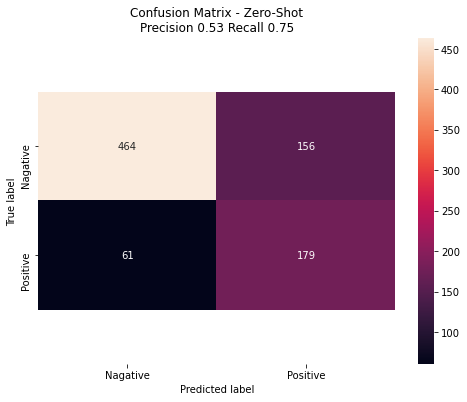

In [32]:
def plot_matrix(target, predicted_binary, name):
    matrix = confusion_matrix(target, predicted_binary)
    TN, FP, FN, TP = matrix.ravel()
    if (TP + FP > 0) and (TP + FN > 0):
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        F =  2 * (precision*recall) / (precision + recall)
    else:
        F = 0
    cm_df = pd.DataFrame(matrix,
                         index = ['Nagative', 'Positive'], 
                         columns = ['Nagative', 'Positive'])
    subtitle = 'Precision ' + str(round(precision, 2)) + ' Recall ' + str(round(recall, 2))
    fig, ax = plt.subplots(figsize=(8,6))
    ax = sns.heatmap(cm_df, annot=True, fmt="d")
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title('Confusion Matrix - ' + name + "\n" + subtitle)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
plot_matrix(olid_test.toxic, olid_test.toxic_predict_binary, name = 'Zero-Shot')


# Olid Few-shot

In [33]:
model.save_weights("/kaggle/working/ckpt.h5")
model.predict(olid_test_dataset, verbose=0)[0:5]

array([[1.1572540e-03],
       [6.1303377e-04],
       [1.0475069e-02],
       [1.8204153e-03],
       [6.8485737e-05]], dtype=float32)

In [34]:
with strategy.scope():
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
n_steps = olid_train_1k.shape[0] // BATCH_SIZE
model.fit(
    olid_train_1k_dataset.repeat(),
    steps_per_epoch=n_steps,
    validation_data=olid_valid_dataset,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    epochs=10
)

olid_test1k = olid_test
olid_test1k.toxic_predict = model.predict(olid_test_dataset, verbose=0)
olid_test1k.to_csv('olid_test_1k.csv', index=False)

print('1k roc is ' + str(roc_auc_score(y_true = olid_test1k.toxic, y_score = olid_test1k.toxic_predict)))

threshold = Find_Optimal_Cutoff(olid_test1k.toxic, olid_test1k.toxic_predict)
print("the optimal threshold is " + str(threshold[0]))
olid_test1k.toxic_predict_binary = [1 if p > threshold[0] else 0 for p in olid_test1k.toxic_predict]

print('1k f1-score is ' + str(f1_score(y_true = olid_test1k.toxic, y_pred = olid_test1k.toxic_predict_binary)))


Epoch 1/10
7/7 [==============================] - 24s 3s/step - accuracy: 0.7790 - loss: 0.6914 - val_accuracy: 0.7849 - val_loss: 0.6870
Epoch 2/10
7/7 [==============================] - 4s 509ms/step - accuracy: 0.7810 - loss: 0.6860 - val_accuracy: 0.7840 - val_loss: 0.6732
Epoch 3/10
7/7 [==============================] - 3s 473ms/step - accuracy: 0.7878 - loss: 0.6499 - val_accuracy: 0.7852 - val_loss: 0.6598
Epoch 4/10
7/7 [==============================] - 3s 479ms/step - accuracy: 0.7936 - loss: 0.6165 - val_accuracy: 0.7836 - val_loss: 0.6470
Epoch 5/10
7/7 [==============================] - 3s 471ms/step - accuracy: 0.7833 - loss: 0.6341 - val_accuracy: 0.7827 - val_loss: 0.6346
Epoch 6/10
7/7 [==============================] - 3s 455ms/step - accuracy: 0.7947 - loss: 0.6177 - val_accuracy: 0.7824 - val_loss: 0.6230
Epoch 7/10
7/7 [==============================] - 3s 449ms/step - accuracy: 0.7867 - loss: 0.6136 - val_accuracy: 0.7812 - val_loss: 0.6119
Epoch 8/10
7/7 [======

In [35]:
tf.tpu.experimental.initialize_tpu_system(tpu)
with strategy.scope():
    model.load_weights("/kaggle/working/ckpt.h5") 
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
model.predict(olid_test_dataset, verbose=0)[0:5]

array([[1.1572540e-03],
       [6.1303377e-04],
       [1.0475069e-02],
       [1.8204153e-03],
       [6.8485737e-05]], dtype=float32)

In [36]:
n_steps = olid_train_2k.shape[0] // BATCH_SIZE
model.fit(
    olid_train_2k_dataset.repeat(),
    steps_per_epoch=n_steps,
    validation_data=olid_valid_dataset,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    epochs=10
)

olid_test2k = olid_test
olid_test2k.toxic_predict = model.predict(olid_test_dataset, verbose=0)
olid_test2k.to_csv('olid_test_2k.csv', index=False)

print('2k roc is ' + str(roc_auc_score(y_true = olid_test2k.toxic, y_score = olid_test2k.toxic_predict)))

threshold = Find_Optimal_Cutoff(olid_test2k.toxic, olid_test2k.toxic_predict)
print("the optimal threshold is " + str(threshold[0]))
olid_test2k.toxic_predict_binary = [1 if p > threshold[0] else 0 for p in olid_test2k.toxic_predict]

print('2k f1-score is ' + str(f1_score(y_true = olid_test2k.toxic, y_pred = olid_test2k.toxic_predict_binary)))


Epoch 1/10
15/15 [==============================] - 23s 2s/step - accuracy: 0.7917 - loss: 0.6512 - val_accuracy: 0.7840 - val_loss: 0.6715
Epoch 2/10
15/15 [==============================] - 4s 255ms/step - accuracy: 0.7879 - loss: 0.6389 - val_accuracy: 0.7836 - val_loss: 0.6436
Epoch 3/10
15/15 [==============================] - 4s 240ms/step - accuracy: 0.7911 - loss: 0.6220 - val_accuracy: 0.7818 - val_loss: 0.6183
Epoch 4/10
15/15 [==============================] - 4s 239ms/step - accuracy: 0.7863 - loss: 0.5923 - val_accuracy: 0.7812 - val_loss: 0.5960
Epoch 5/10
15/15 [==============================] - 4s 236ms/step - accuracy: 0.7901 - loss: 0.5626 - val_accuracy: 0.7818 - val_loss: 0.5768
Epoch 6/10
15/15 [==============================] - 4s 250ms/step - accuracy: 0.7847 - loss: 0.5550 - val_accuracy: 0.7824 - val_loss: 0.5604
Epoch 7/10
15/15 [==============================] - 5s 343ms/step - accuracy: 0.7831 - loss: 0.5389 - val_accuracy: 0.7830 - val_loss: 0.5468
Epoch 8/

In [37]:
tf.tpu.experimental.initialize_tpu_system(tpu)
with strategy.scope():
    model.load_weights("/kaggle/working/ckpt.h5") 
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
model.predict(olid_test_dataset, verbose=0)[0:5]

array([[1.1572540e-03],
       [6.1303377e-04],
       [1.0475069e-02],
       [1.8204153e-03],
       [6.8485737e-05]], dtype=float32)

In [38]:
n_steps = olid_train_5k.shape[0] // BATCH_SIZE 
model.fit(
    olid_train_5k_dataset.repeat(),
    steps_per_epoch=n_steps,
    validation_data=olid_valid_dataset,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    epochs=10
)

olid_test5k = olid_test
olid_test5k.toxic_predict = model.predict(olid_test_dataset, verbose=0)
olid_test5k.to_csv('olid_test_5k.csv', index=False)

print('5k roc is ' + str(roc_auc_score(y_true = olid_test5k.toxic, y_score = olid_test5k.toxic_predict)))

threshold = Find_Optimal_Cutoff(olid_test5k.toxic, olid_test5k.toxic_predict)
print("the optimal threshold is " + str(threshold[0]))
olid_test5k.toxic_predict_binary = [1 if p > threshold[0] else 0 for p in olid_test5k.toxic_predict]

print('5k f1-score is ' + str(f1_score(y_true = olid_test5k.toxic, y_pred = olid_test5k.toxic_predict_binary)))

Epoch 1/10
39/39 [==============================] - 25s 654ms/step - accuracy: 0.7792 - loss: 0.6393 - val_accuracy: 0.7836 - val_loss: 0.6299
Epoch 2/10
39/39 [==============================] - 5s 135ms/step - accuracy: 0.7900 - loss: 0.5674 - val_accuracy: 0.7833 - val_loss: 0.5774
Epoch 3/10
39/39 [==============================] - 5s 131ms/step - accuracy: 0.7919 - loss: 0.5334 - val_accuracy: 0.7824 - val_loss: 0.5429
Epoch 4/10
39/39 [==============================] - 5s 128ms/step - accuracy: 0.7896 - loss: 0.5129 - val_accuracy: 0.7821 - val_loss: 0.5215
Epoch 5/10
39/39 [==============================] - 5s 128ms/step - accuracy: 0.7913 - loss: 0.4920 - val_accuracy: 0.7812 - val_loss: 0.5081
Epoch 6/10
39/39 [==============================] - 5s 125ms/step - accuracy: 0.7896 - loss: 0.4856 - val_accuracy: 0.7827 - val_loss: 0.4993
Epoch 7/10
39/39 [==============================] - 5s 126ms/step - accuracy: 0.7872 - loss: 0.4752 - val_accuracy: 0.7846 - val_loss: 0.4929
Epoch

In [39]:
tf.tpu.experimental.initialize_tpu_system(tpu)

with strategy.scope():
    model.load_weights("/kaggle/working/ckpt.h5") 
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
model.predict(olid_test_dataset, verbose=0)[0:5]

array([[1.1572540e-03],
       [6.1303377e-04],
       [1.0475069e-02],
       [1.8204153e-03],
       [6.8485737e-05]], dtype=float32)

In [40]:
n_steps = olid_train.shape[0] // BATCH_SIZE
model.fit(
    olid_train_dataset.repeat(),
    steps_per_epoch=n_steps,
    validation_data=olid_valid_dataset,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    epochs=10
)

olid_test10k = olid_test
olid_test10k.toxic_predict = model.predict(olid_test_dataset, verbose=0)
olid_test10k.to_csv('olid_test_10k.csv', index=False)

print('10k roc is ' + str(roc_auc_score(y_true = olid_test10k.toxic, y_score = olid_test10k.toxic_predict)))

threshold = Find_Optimal_Cutoff(olid_test10k.toxic, olid_test10k.toxic_predict)
print("the optimal threshold is " + str(threshold[0]))
olid_test10k.toxic_predict_binary = [1 if p > threshold[0] else 0 for p in olid_test10k.toxic_predict]

print('10k f1-score is ' + str(f1_score(y_true = olid_test10k.toxic, y_pred = olid_test10k.toxic_predict_binary)))


Epoch 1/10
78/78 [==============================] - 26s 334ms/step - accuracy: 0.7862 - loss: 0.6056 - val_accuracy: 0.7815 - val_loss: 0.5751
Epoch 2/10
78/78 [==============================] - 8s 105ms/step - accuracy: 0.7906 - loss: 0.5178 - val_accuracy: 0.7793 - val_loss: 0.5208
Epoch 3/10
78/78 [==============================] - 7s 84ms/step - accuracy: 0.7906 - loss: 0.4872 - val_accuracy: 0.7769 - val_loss: 0.5003
Epoch 4/10
78/78 [==============================] - 6s 82ms/step - accuracy: 0.7908 - loss: 0.4753 - val_accuracy: 0.7843 - val_loss: 0.4893
Epoch 5/10
78/78 [==============================] - 7s 85ms/step - accuracy: 0.7913 - loss: 0.4716 - val_accuracy: 0.7852 - val_loss: 0.4821
Epoch 6/10
78/78 [==============================] - 6s 81ms/step - accuracy: 0.7906 - loss: 0.4685 - val_accuracy: 0.7840 - val_loss: 0.4777
Epoch 7/10
78/78 [==============================] - 7s 88ms/step - accuracy: 0.7916 - loss: 0.4644 - val_accuracy: 0.7846 - val_loss: 0.4745
Epoch 8/10